In [1]:
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets

In [2]:
def a(v):
    l = np.sum(np.abs(v))
    if l == 1:
        return 0.5
    if l == 2:
        return 0.25

In [3]:
def get_elements_probas(p, mu, kappa, beta, a, allowed_jumps, dim=2):
    elements = ['die', '(1, 1)', '(0, 2)'] + ['x + ' + str(x) for x in allowed_jumps]
    
    probas = [mu(p), beta(p, 1, 1), beta(p, 0, 2)]
    probas += [a(np.array(x).reshape(dim)) for x in allowed_jumps]
    
    return elements, probas / np.sum(probas)

In [4]:
class Point():
    def __init__(self, point_type, x, t_1, t_2):
        self.point_type = point_type
        self.x = x
        self.t_1 = t_1
        self.t_2 = t_2
        
    def shifted(self, v, dt):
        v = np.array(v)
        return Point(self.point_type, self.x + v, self.t_2, self.t_2 + dt)
    
    def __str__(self):
        return '{} {} {} {} {}'.format(self.point_type, self.x[0], self.x[1], self.t_1, self.t_2)

In [5]:
def init_points(size, dim=2):
    R = []
    if dim == 1:
        for i in range(-size, size, 1):
            R.append(Point(1, np.array([i]), 0, 0))
            R.append(Point(2, np.array([i]), 0, 0))  
        return R
    
    if dim == 2:
        for i in range(-size, size, 1):
            for j in range(-size, size, 1):
                R.append(Point(1, np.array([i, j]), 0, 0))
                R.append(Point(2, np.array([i, j]), 0, 0))              
        return R
    
    if dim == 3:
        for i in range(-size, size, 1):
            for j in range(-size, size, 1):
                for k in range(-size, size, 1):
                    R.append(Point(1, np.array([i, j, k]), 0, 0))
                    R.append(Point(2, np.array([i, j, k]), 0, 0))              
        return R

In [6]:
def get_x_str(x):
    if len(x) == 1:
        return str((int(x[0])))
    if len(x) == 2:
        return str((int(x[0]), int(x[1])))
    if len(x) == 3:
        return str((int(x[0]), int(x[1]), int(x[2]))) 


def append_points(R, k, l, p, dt, noise_std, dim=2):
    for i in range(k):
        coord_noise = np.random.normal(0, noise_std, dim)
        p = Point(1, p.x + coord_noise, p.t_2, p.t_2 + dt)
        R.append(p)
        
    for i in range(l):
        coord_noise = np.random.normal(0, noise_std, dim)
        p = Point(2, p.x + coord_noise, p.t_2, p.t_2 + dt)
        R.append(p)


def step(R, H, dt, idx, mu, kappa, beta, a, noise_std, allowed_jumps, dim=2):
    p = R[idx]
    
    elements, probas = get_elements_probas(p, mu, kappa, beta, a, allowed_jumps, dim)
    
    action = np.random.choice(a=elements, p=probas, size=1)[0]
    
    coord_noise = np.random.normal(0, noise_std, dim)
    
    if action[0:3] == 'x +':
        shift = [int(s) for s in action[4:].replace(')', '').replace('(', '').split(', ')]

        shifted = p.shifted(shift + coord_noise, dt)
        R.append(shifted)
        
    elif action[0] == '(':
        num_childs = [int(s) for s in action.replace(')', '').replace('(', '').split(', ')]
        
        append_points(R, num_childs[0], num_childs[1], p, dt, noise_std, dim)
    
        
    H.append(p)
    del R[idx]

In [7]:
def simulate(R, H, T, mu, kappa, beta, a, noise_std, allowed_jumps, max_steps=10000, dim=2):
    k = 0

    
    pbar = tqdm(total=max_steps, position=0, leave=True)
    while k < max_steps:
        i = 0
        idx = 0
        found = 0
        
        while 1:
            if len(R) == 0:
                break

            idx = np.random.randint(len(R))

            if R[idx].t_2 < T:
                found = 1
                break
            if i >= len(R):
                break
            
            i += 1
        
        if len(R) == 0:
            return
        
        if found != 1:
            return
        
        dt = np.random.exponential()
        step(R, H, dt, idx, mu, kappa, beta, a, noise_std, allowed_jumps, dim)
        
        k += 1
        pbar.update(1)

    return R, H

In [8]:
import numpy as np
from ipywidgets import interact, FloatSlider, fixed
import plotly.graph_objects as go
import plotly.io as pio

pio.renderers.default = 'notebook_connected'

def plot_points_interactive_1(t, points, interval_tree, lims, dim=2):
    
    fig = go.FigureWidget()
    
    if dim == 3:
        fig.add_scatter3d(mode='markers')
    else:
        fig.add_scatter(mode='markers')
    
    idx = list(map(lambda i: i.data, interval_tree.at(t)))
    points_t = points[idx]

    color_dict = {1: 'blue', 2: 'red'}
    coords = np.array(list(map(lambda p: p.x, points_t)))
    labels = np.array(list(map(lambda p: color_dict[p.point_type], points_t)))

    if len(points_t) == 0:
        if dim == 3:
            fig.data[0].x = fig.data[0].y = fig.data[0].z = []
        else:
            fig.data[0].x = fig.data[0].y = []
        return

    if dim == 3:
        fig.data[0].x = coords[:, 0]
        fig.data[0].y = coords[:, 1]
        fig.data[0].z = coords[:, 2]
    else:
        fig.data[0].x = coords[:, 0]
        fig.data[0].y = coords[:, 1] if dim == 2 else np.repeat(0, len(coords))

    fig.data[0].marker.color = labels
    
    fig.show()

def plot_points_interactive_plotly(points, T, dim, width=600, height=400):
    fig = go.FigureWidget()
    
    lims = get_min_coords(points, dim)
    

    if dim == 3:
        fig.add_scatter3d(mode='markers')
    else:
        fig.add_scatter(mode='markers')
        
    
    def plot_points_interactive(t, points, interval_tree, lims, dim=2):
        idx = list(map(lambda i: i.data, interval_tree.at(t)))
        points_t = points[idx]

        color_dict = {1: 'blue', 2: 'red'}
        coords = np.array(list(map(lambda p: p.x, points_t)))
        labels = np.array(list(map(lambda p: color_dict[p.point_type], points_t)))

        if len(points_t) == 0:
            if dim == 3:
                fig.data[0].x = fig.data[0].y = fig.data[0].z = []
            else:
                fig.data[0].x = fig.data[0].y = []
            return

        if dim == 3:
            fig.data[0].x = coords[:, 0]
            fig.data[0].y = coords[:, 1]
            fig.data[0].z = coords[:, 2]
        else:
            fig.data[0].x = coords[:, 0]
            fig.data[0].y = coords[:, 1] if dim == 2 else np.repeat(0, len(coords))

        fig.data[0].marker.color = labels
    
    fig.update_layout(width=width, height=height)
    
    
    max_t = get_max_t(points) - 0.01
    interact(plot_points_interactive,
             t=FloatSlider(min=0, max=min(max_t, T), step=0.01, continuous_update=False),
             points=fixed(points),
             interval_tree=fixed(build_interval_tree(points)),
             lims=fixed(lims),
             dim=fixed(dim))
    
    return fig


In [9]:
def get_max_t(all_points):
    max_t = 0
    for p in all_points:
        if p.t_2 > max_t:
            max_t = p.t_2
    
    return max_t

def get_min_coords(all_points, dim=2):
    mins = [0 for i in range(dim)]
    maxs = [0 for i in range(dim)]
    
    for point in all_points:
        for i in range(dim):
            if point.x[i] < mins[i]:
                mins[i] = point.x[i]
            if point.x[i] > maxs[i]:
                maxs[i] = point.x[i]

    return list(zip(mins, maxs))

In [10]:
from intervaltree import Interval, IntervalTree

def build_interval_tree(points):
    interval_tree = IntervalTree()
    
    for i in tqdm(range(len(points)), position=0, leave=True):
        p = points[i]
        if p.t_1 + p.t_2 > 0:
            interval_tree.add(Interval(p.t_1, p.t_2, i))

    return interval_tree

In [11]:
def beta(p, k, l, point_tree_dict):
    if p.point_type == 1:
        return 0
    
    if p.point_type == 2:
        if k == 1:
            if l == 1:
                return 0.5
        if k == 0:
            if l == 2:
                return 0.5      
    else:
        return 0

In [12]:
def mu(p):
    return 0.1

In [13]:
def run_simulation(allowed_jumps,
                   mu = mu, 
                   kappa = np.array([-1, 0.1, 0.1]),
                   size = 20,
                   noise_std = 0.01,
                   beta = beta,
                   a = a,
                   init_points=init_points,
                   max_steps=5000,
                   T=500,
                   plot=True,
                   dim=2):

    R = init_points(size, dim)
    H = []

    simulate(R, H, T, mu, kappa, beta, a, noise_std, allowed_jumps, max_steps, dim)

    all_points = np.array(R + H)

    if plot:
        plot_points_interactive_plotly(all_points, T, dim).show()
    
    return all_points
    

In [14]:
from numba import jit, prange

def get_points_share_sqrt(points, T, shares=True, interval_tree=None):
    ts = []
    
    if interval_tree is None:
        interval_tree = build_interval_tree(points)
    
    counts_mens = []
    counts_womens = []
    
    
    for t in tqdm(np.arange(0.01, T, 5)):
        idx = list(map(lambda i: i.data, interval_tree.at(t)))
        if len(idx) == 0:
            continue
        
        ts.append(t)
        
        points_t = points[idx]
        
        color_dict = {1: 'blue', 2: 'red'}
        
        labels = np.array(list(map(lambda p: p.point_type, points_t)))
        coords = np.array(list(map(lambda p: p.x, points_t)))
        
        dists = np.sqrt(np.apply_along_axis(func1d=np.sum, arr=coords * coords, axis=1))
        
        count_mens = np.sum(labels[(dists > np.sqrt(t))] == 1)
        count_womens = np.sum(labels[(dists > np.sqrt(t))] == 2)
        
        if shares:
            count_mens_all = np.sum(labels == 1)
            count_womens_all = np.sum(labels == 2)
            
            counts_mens.append(count_mens / count_mens_all)
            counts_womens.append(count_womens / count_womens_all)
        else:
            counts_mens.append(count_mens)
            counts_womens.append(count_womens)
        
        
    plt.plot(ts, counts_mens, label='Men')
    plt.plot(ts, counts_womens, label='Women')
    plt.xlabel('t')
    if shares:
        plt.ylabel('Доля частиц')
        plt.suptitle('Доля мужских и женских частиц, выходящих за sqrt(t)')
    else:
        plt.ylabel('Количество частиц')
        plt.suptitle('Количество мужских и женских частиц, выходящих за sqrt(t)')
        
    plt.legend()
    plt.show()
    
    return interval_tree

In [15]:
from numba import jit, prange

def get_points_share_sqrt_all(points, T, shares=True, interval_tree=None):
    ts = []
    
    if interval_tree is None:
        interval_tree = build_interval_tree(points)
    
    counts_all = []
    
    
    for t in tqdm(np.arange(0.01, T, 5)):
        idx = list(map(lambda i: i.data, interval_tree.at(t)))
        if len(idx) == 0:
            continue
        
        ts.append(t)
        
        points_t = points[idx]
        
        color_dict = {1: 'blue', 2: 'red'}
        
        labels = np.array(list(map(lambda p: p.point_type, points_t)))
        coords = np.array(list(map(lambda p: p.x, points_t)))
        
        dists = np.sqrt(np.apply_along_axis(func1d=np.sum, arr=coords * coords, axis=1))
        
        count_all = np.sum((dists > np.sqrt(t)))
        
        if shares:
            count_total = len(labels)
            counts_all.append(count_all / count_total)
        else:
            counts_all.append(count_all)
        
        
    plt.plot(ts, counts_all)
    plt.xlabel('t')
    if shares:
        plt.ylabel('Доля частиц')
        plt.suptitle('Доля частиц, выходящих за sqrt(t)')
    else:
        plt.ylabel('Количество частиц')
        plt.suptitle('Количество частиц, выходящих за sqrt(t)')
        
    plt.legend()
    plt.show()
    
    return interval_tree

In [16]:
from pandarallel import pandarallel

pandarallel.initialize(progress_bar=True)

INFO: Pandarallel will run on 10 workers.
INFO: Pandarallel will use standard multiprocessing data transfer (pipe) to transfer data between the main process and workers.


In [17]:
def save_simulation(points, file_nm, dim):
    point_types = [p.point_type for p in points]
    
    xs = [[] for i in range(dim)]
    
    for i in range(dim):
        xs[i] = [p.x[i] for p in points]
        
    t_1 = [p.t_1 for p in points]
    t_2 = [p.t_2 for p in points]
    
    data = {}
    for i in range(dim):
        data['x_' + str(i)] = xs[i]
    
    data['point_type'] = point_types
    data['t_1'] = t_1
    data['t_2'] = t_2

    df = pd.DataFrame(data=data)

    df.to_csv(file_nm + '.csv', index=False)


def load_simulation(file_nm, dim, T=2000, plot=False):
    df = pd.read_csv(file_nm + '.csv')
    
    all_points = df.parallel_apply(df, lambda row: Point(row.point_type,
                                            np.array([row['x_{}'.format(i)] for i in range(dim)]),
                                            row.t_1,
                                            row.t_2))
    

    


    if plot:
        plot_points_interactive(all_points, T)

    return all_points


In [148]:
from numba import jit, prange

def plot_mean_r(points, T, shares=True, interval_tree=None):
    ts = []
    
    if interval_tree is None:
        interval_tree = build_interval_tree(points)
    
    mean_mens = []
    mean_womens = []
    
    
    for t in tqdm(np.arange(0.01, T, 5)):
        idx = list(map(lambda i: i.data, interval_tree.at(t)))
        if len(idx) == 0:
            continue
        
        ts.append(t)
        
        points_t = points[idx]
        
        color_dict = {1: 'blue', 2: 'red'}
        
        labels = np.array(list(map(lambda p: p.point_type, points_t)))
        coords = np.array(list(map(lambda p: p.x, points_t)))
        
        dists = np.sqrt(np.apply_along_axis(func1d=np.sum, arr=coords * coords, axis=1))
        
        mean_men = np.mean(dists[labels == 1])
        mean_women = np.mean(dists[labels == 2])
        
        mean_mens.append(mean_men)
        mean_womens.append(mean_women)
        
    plt.plot(ts, mean_mens, label='Men')
    plt.plot(ts, mean_womens, label='Women')
    plt.xlabel('t')
    
    plt.ylabel('Cреднее расстояние частиц от 0')
        
    plt.legend()
    plt.show()
    
    return interval_tree

In [19]:
allowed_jumps = [
    (1)
]

In [19]:
def beta(p, k, l):
    if p.point_type == 1:
        return 0
    
    if p.point_type == 2:
        if k == 1:
            if l == 1:
                return 0.2
        if k == 0:
            if l == 2:
                return 0.2
    else:
        return 0

In [20]:
%%time

all_points = run_simulation(
    mu = mu,
    max_steps=10000000,
    init_points=init_points,
    T=500,
    beta=beta,
    plot=False,
    allowed_jumps=allowed_jumps,
    dim=1
)

  1%|▎                             | 100613/10000000 [00:02<04:11, 39349.55it/s]

KeyboardInterrupt: 

In [94]:
interval_tree = build_interval_tree(all_points)

100%|████████████████████████████| 11003823/11003823 [02:04<00:00, 88451.18it/s]


In [95]:
plot_points_interactive_1(150, all_points, interval_tree, [-100, 100], dim=1)

100%|███████████████████████████████████████████| 40/40 [00:13<00:00,  2.97it/s]


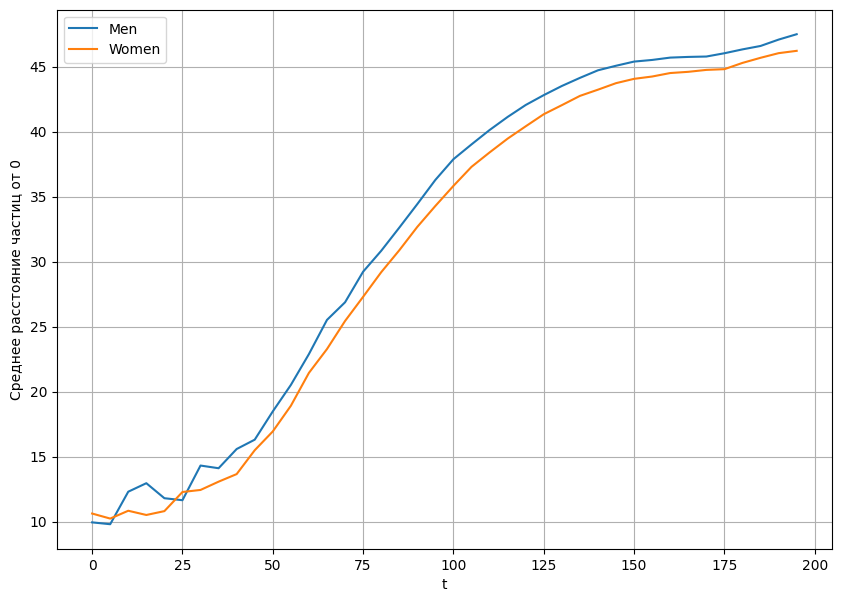

In [97]:
_ = plot_mean_r(all_points, 200, interval_tree)

In [98]:
allowed_jumps = [
    (0, 1),
    (1, 0)
]

In [99]:
%%time

all_points = run_simulation(
    mu = mu,
    max_steps=10000000,
    init_points=init_points,
    T=500,
    beta=beta,
    plot=False,
    allowed_jumps=allowed_jumps,
    dim=2
)

100%|████████████████████████████| 10000000/10000000 [09:32<00:00, 17454.89it/s]


CPU times: user 9min 30s, sys: 32 s, total: 10min 2s
Wall time: 9min 45s


In [100]:
interval_tree = build_interval_tree(all_points)

100%|████████████████████████████| 10674144/10674144 [02:08<00:00, 83331.97it/s]


In [101]:
plot_points_interactive_1(150, all_points, interval_tree, [-100, 100], dim=2)

In [102]:
_ = plot_mean_r(all_points, 200, interval_tree)

100%|███████████████████████████████████████████| 40/40 [00:14<00:00,  2.71it/s]


In [104]:
allowed_jumps = [
    (0, 0, 1),
    (0, 1, 0),
    (1, 0, 0)
]

In [115]:
%%time

all_points = run_simulation(
    mu = mu,
    max_steps=100000000,
    init_points=init_points,
    T=500,
    beta=beta,
    plot=False,
    allowed_jumps=allowed_jumps,
    dim=3
)

100%|█████████████████████████| 100000000/100000000 [8:11:03<00:00, 3394.04it/s]


CPU times: user 7h 36min 17s, sys: 31min 39s, total: 8h 7min 57s
Wall time: 8h 15min 42s


In [116]:
interval_tree = build_interval_tree(all_points)

 49%|███████████▏           | 51080389/105109825 [1:02:21<1:05:57, 13653.33it/s]


KeyboardInterrupt: 

In [ ]:
plot_points_interactive_1(150, all_points, interval_tree, [-100, 100], dim=3)

In [ ]:
_ = plot_mean_r(all_points, 200, interval_tree)

In [ ]:
доля выходящих траекторий
1 частица не размножается, dim=1, 2, 3

## Большие уклонения без размножения и смерти, d = 1

In [149]:
allowed_jumps = [
    (-1),
    (1)
]

In [150]:
def beta(p, k, l):
    if p.point_type == 1:
        return 0
    
    if p.point_type == 2:
        if k == 1:
            if l == 1:
                return 0.0
        if k == 0:
            if l == 2:
                return 0.0
    else:
        return 0

In [22]:
def mu(p):
    return 0.0

In [23]:
def init_points_zero(size, dim=2):
    R = []
    for i in range(size):
        R.append(Point(1, np.repeat(0, dim), 0, 0))

    return R

In [24]:
%%time

all_points = run_simulation(
    mu = mu,
    max_steps=5000000,
    init_points=init_points_zero,
    T=3000,
    beta=beta,
    plot=False,
    allowed_jumps=allowed_jumps,
    dim=1,
    size=1000
)

 60%|██████████████████            | 3001816/5000000 [01:12<00:48, 41387.60it/s]


CPU times: user 1min 12s, sys: 1.89 s, total: 1min 14s
Wall time: 1min 13s


In [25]:
interval_tree = get_points_share_sqrt_all(all_points, 3000, shares=False)

100%|████████████████████████████████████████| 600/600 [00:02<00:00, 236.45it/s]
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


100%|████████████████████████████████████████| 600/600 [00:02<00:00, 238.86it/s]
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


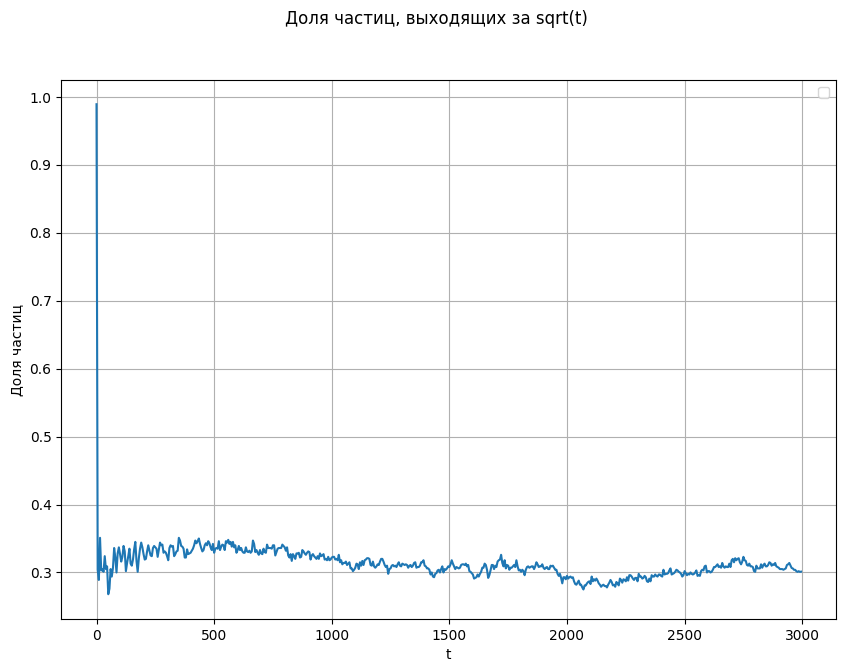

In [26]:
_ = get_points_share_sqrt_all(all_points, 3000, interval_tree=interval_tree, shares=True)

## Большие уклонения без размножения и смерти, d = 2

In [27]:
allowed_jumps = [
    (0, 1),
    (1, 0),
    (0, -1),
    (-1, 0)
]

In [28]:
def beta(p, k, l):
    if p.point_type == 1:
        return 0
    
    if p.point_type == 2:
        if k == 1:
            if l == 1:
                return 0.0
        if k == 0:
            if l == 2:
                return 0.0
    else:
        return 0

In [29]:
def mu(p):
    return 0.0

In [30]:
def init_points_zero(size, dim=2):
    R = []
    for i in range(size):
        R.append(Point(1, np.repeat(0, dim), 0, 0))

    return R

In [31]:
%%time

all_points = run_simulation(
    mu = mu,
    max_steps=5000000,
    init_points=init_points_zero,
    T=3000,
    beta=beta,
    plot=False,
    allowed_jumps=allowed_jumps,
    dim=2,
    size=1000
)

 60%|██████████████████            | 3003443/5000000 [01:34<01:02, 31734.68it/s]


CPU times: user 1min 34s, sys: 6.02 s, total: 1min 40s
Wall time: 1min 36s


In [34]:
interval_tree = get_points_share_sqrt_all(all_points, 3000, shares=False)

100%|████████████████████████████████████████| 600/600 [00:02<00:00, 222.53it/s]
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


In [35]:
_ = get_points_share_sqrt_all(all_points, 3000, interval_tree=interval_tree, shares=True)

100%|████████████████████████████████████████| 600/600 [00:02<00:00, 203.86it/s]
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


## Большие уклонения без размножения и смерти, d = 3

In [19]:
def get_unit_vectors(n):
    unit_vectors = []
    for i in range(n):
        vector = [0]*n
        vector[i] = 1
        unit_vectors.append(tuple(vector))
        vector[i] = -1
        unit_vectors.append(tuple(vector))
    return unit_vectors


In [45]:
allowed_jumps = get_unit_vectors(3)

In [37]:
def beta(p, k, l):
    if p.point_type == 1:
        return 0
    
    if p.point_type == 2:
        if k == 1:
            if l == 1:
                return 0.0
        if k == 0:
            if l == 2:
                return 0.0
    else:
        return 0

In [38]:
def mu(p):
    return 0.0

In [39]:
%%time

all_points = run_simulation(
    mu = mu,
    max_steps=5000000,
    init_points=init_points_zero,
    T=3000,
    beta=beta,
    plot=False,
    allowed_jumps=allowed_jumps,
    dim=3,
    size=1000
)

 60%|█████████████████▉            | 2999929/5000000 [01:47<01:11, 27847.65it/s]

CPU times: user 1min 47s, sys: 3.75 s, total: 1min 51s
Wall time: 1min 49s


In [40]:
interval_tree = get_points_share_sqrt_all(all_points, 3000, shares=False)

100%|████████████████████████████████████████| 600/600 [00:02<00:00, 225.11it/s]
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


100%|████████████████████████████████████████| 600/600 [00:02<00:00, 204.62it/s]
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


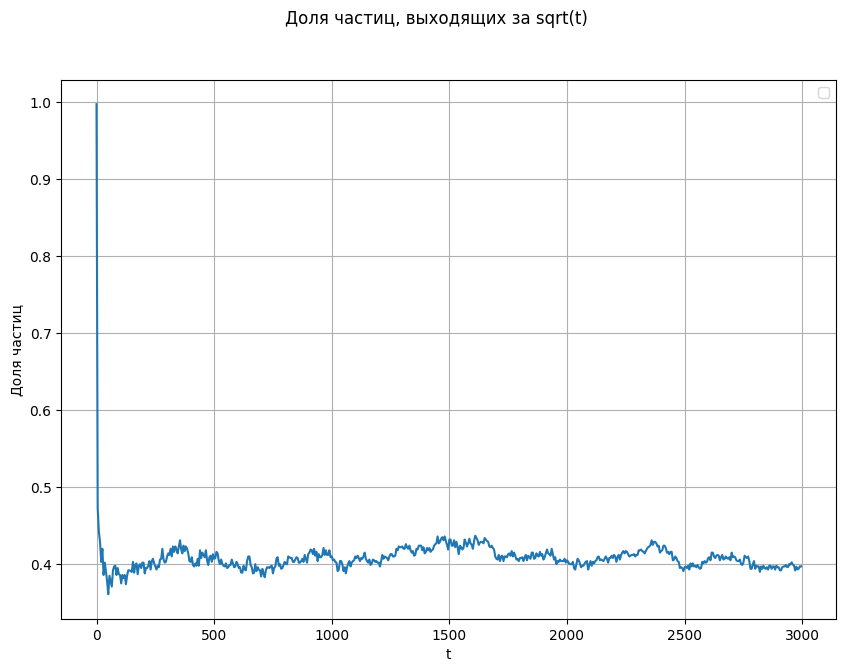

In [41]:
_ = get_points_share_sqrt_all(all_points, 3000, interval_tree=interval_tree, shares=True)

## Большие уклонения без размножения и смерти, d = 5

In [46]:
allowed_jumps = get_unit_vectors(5)

In [48]:
def beta(p, k, l):
    if p.point_type == 1:
        return 0
    
    if p.point_type == 2:
        if k == 1:
            if l == 1:
                return 0.0
        if k == 0:
            if l == 2:
                return 0.0
    else:
        return 0

In [49]:
def mu(p):
    return 0.0

In [50]:
%%time

all_points = run_simulation(
    mu = mu,
    max_steps=5000000,
    init_points=init_points_zero,
    T=3000,
    beta=beta,
    plot=False,
    allowed_jumps=allowed_jumps,
    dim=5,
    size=1000
)

 60%|██████████████████            | 3000660/5000000 [02:31<01:41, 19755.44it/s]


CPU times: user 2min 28s, sys: 10.8 s, total: 2min 39s
Wall time: 2min 33s


100%|████████████████████████████████████████| 600/600 [00:02<00:00, 232.29it/s]
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


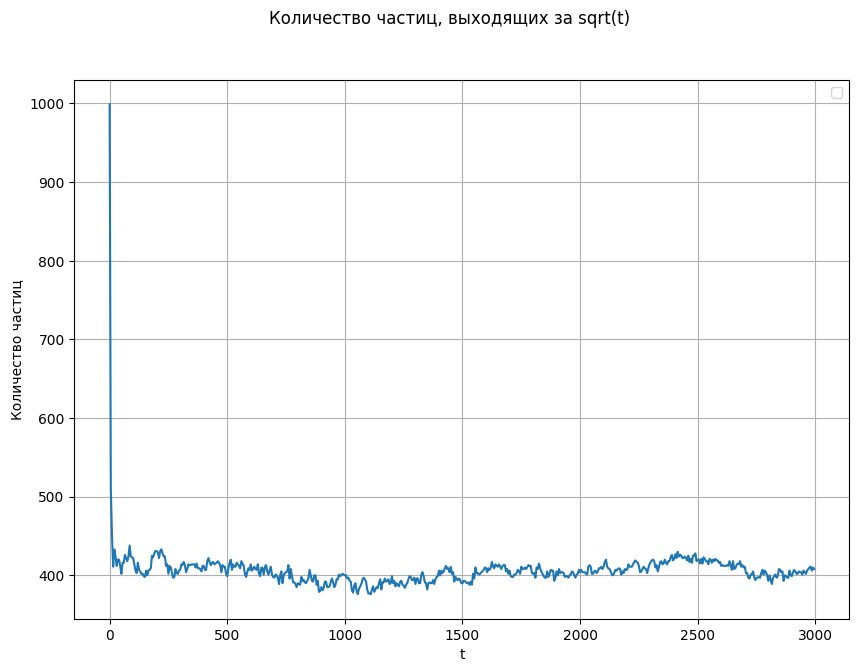

In [51]:
interval_tree = get_points_share_sqrt_all(all_points, 3000, shares=False)

In [52]:
_ = get_points_share_sqrt_all(all_points, 3000, interval_tree=interval_tree, shares=True)

100%|████████████████████████████████████████| 600/600 [00:02<00:00, 230.97it/s]
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


## Большие уклонения без размножения и смерти, d = 10

In [53]:
allowed_jumps = get_unit_vectors(10)

In [54]:
def beta(p, k, l):
    if p.point_type == 1:
        return 0
    
    if p.point_type == 2:
        if k == 1:
            if l == 1:
                return 0.0
        if k == 0:
            if l == 2:
                return 0.0
    else:
        return 0

In [55]:
def mu(p):
    return 0.0

In [56]:
%%time

all_points = run_simulation(
    mu = mu,
    max_steps=5000000,
    init_points=init_points_zero,
    T=3000,
    beta=beta,
    plot=False,
    allowed_jumps=allowed_jumps,
    dim=10,
    size=1000
)

 60%|█████████████████▉            | 2996068/5000000 [04:07<02:45, 12128.86it/s]


CPU times: user 4min, sys: 13.3 s, total: 4min 13s
Wall time: 4min 9s


In [57]:
interval_tree = get_points_share_sqrt_all(all_points, 3000, shares=False)

100%|████████████████████████████████████████| 600/600 [00:03<00:00, 190.30it/s]
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


100%|████████████████████████████████████████| 600/600 [00:02<00:00, 203.78it/s]
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


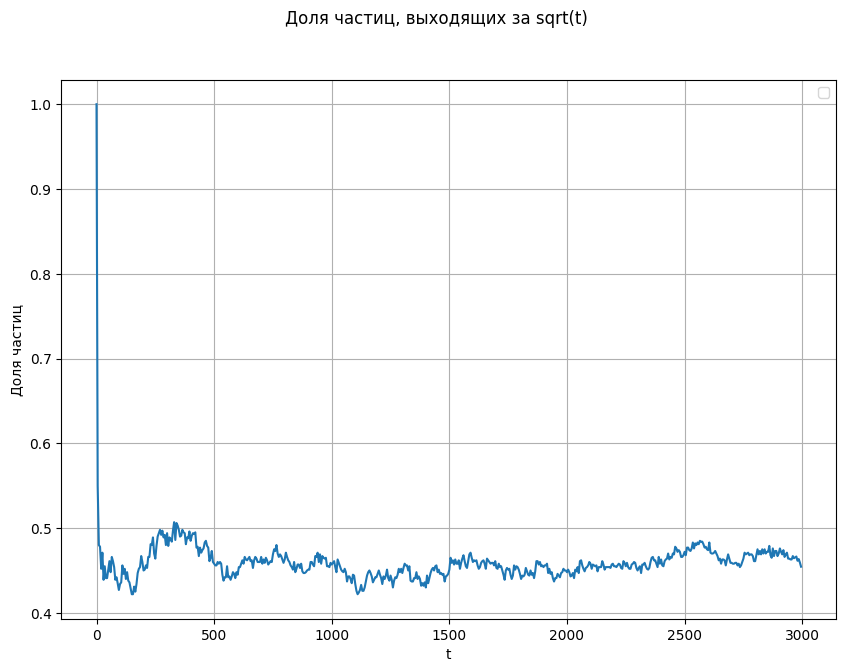

In [58]:
_ = get_points_share_sqrt_all(all_points, 3000, interval_tree=interval_tree, shares=True)

## Большие уклонения с размножением и гибелью в 0, d = 1

In [151]:
allowed_jumps = [
    (-1),
    (1)
]

In [152]:
def mu(p):
    dim = p.x.shape[0]
    
    at_zero = np.sum(np.array(list(map(lambda x: round(x, 0), p.x))) == 0) == dim
    if at_zero:
        return 0.2
    else:
        return 0

In [154]:
def beta(p, k, l):
    if p.point_type == 1:
        return 0
    
    dim = p.x.shape[0]
    
    at_zero = np.sum(np.array(list(map(lambda x: round(x, 0), p.x))) == 0) == dim
    
    if p.point_type == 2 and at_zero:
        if k == 1:
            if l == 1:
                return 0.3
        if k == 0:
            if l == 2:
                return 0.3
    else:
        return 0

In [39]:
dim = 3
p = Point(1, np.array([0.5, 0.1, 0.1]), 0, 0)

at_zero = np.sum(np.array(list(map(lambda x: round(x, 0), p.x))) == 0) == dim

In [155]:
%%time

all_points = run_simulation(
    mu = mu,
    max_steps=50000000,
    init_points=init_points,
    T=3000,
    beta=beta,
    plot=False,
    allowed_jumps=allowed_jumps,
    dim=1
)

100%|████████████████████████████| 50000000/50000000 [41:52<00:00, 19901.74it/s]


CPU times: user 38min 20s, sys: 4min 32s, total: 42min 53s
Wall time: 42min 51s


100%|████████████████████████████| 50232615/50232615 [18:57<00:00, 44160.23it/s]

 89%|████████████████████████████████████▋    | 286/320 [02:43<03:03,  5.41s/it]


100%|█████████████████████████████████████████| 320/320 [06:47<00:00,  1.27s/it]


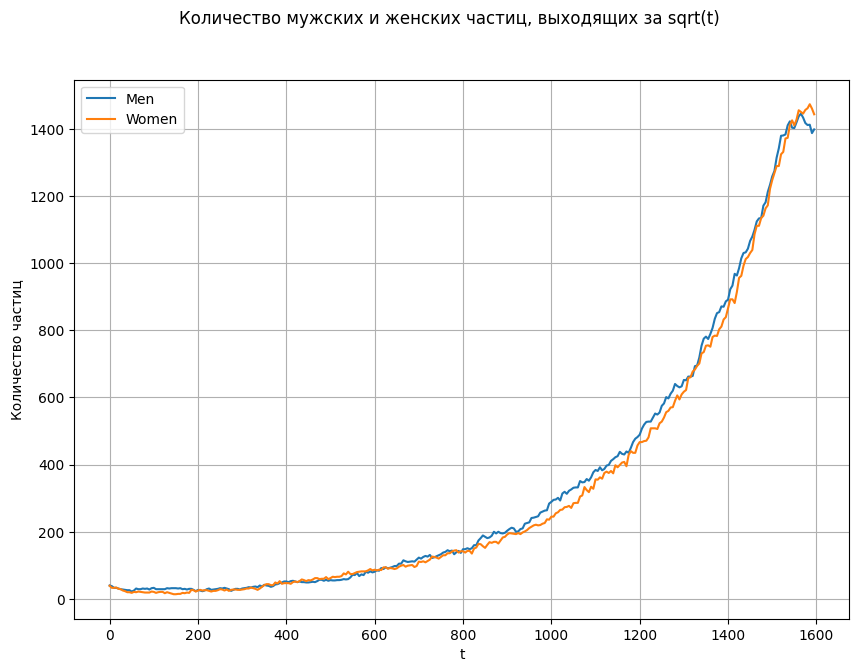

In [156]:
interval_tree = get_points_share_sqrt(all_points, 1600, shares=False)


 92%|█████████████████████████████████████▌   | 293/320 [03:30<02:42,  6.01s/it]


100%|█████████████████████████████████████████| 320/320 [07:09<00:00,  1.34s/it]


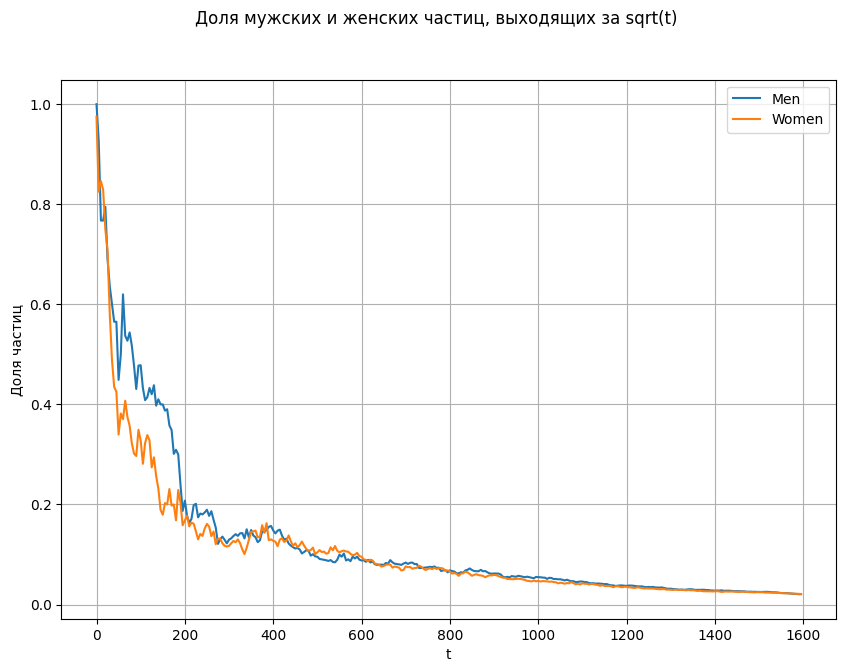

In [157]:
_ = get_points_share_sqrt(all_points, 1600, interval_tree=interval_tree, shares=True)

## Большие уклонения с размножением и гибелью в 0, d = 2

In [158]:
allowed_jumps = get_unit_vectors(2)

In [26]:
def beta(p, k, l):
    if p.point_type == 1:
        return 0
    
    dim = p.x.shape[0]
    
    at_zero = np.sum(np.array(list(map(lambda x: round(x, 0), p.x))) == 0) == dim
    
    if p.point_type == 2 and at_zero:
        if k == 1:
            if l == 1:
                return 0.4
        if k == 0:
            if l == 2:
                return 0.4
    else:
        return 0

In [27]:
%%time

all_points = run_simulation(
    mu = mu,
    max_steps=50000000,
    init_points=init_points,
    T=3000,
    beta=beta,
    plot=False,
    allowed_jumps=allowed_jumps,
    dim=2
)

  0%|                                           | 0/200000000 [3:57:38<?, ?it/s]


ValueError: cannot reshape array of size 3 into shape (2,)

100%|██████████████████████████████| 9787910/9787910 [02:00<00:00, 81525.67it/s]

100%|█████████████████████████████████████████| 600/600 [00:13<00:00, 44.96it/s]


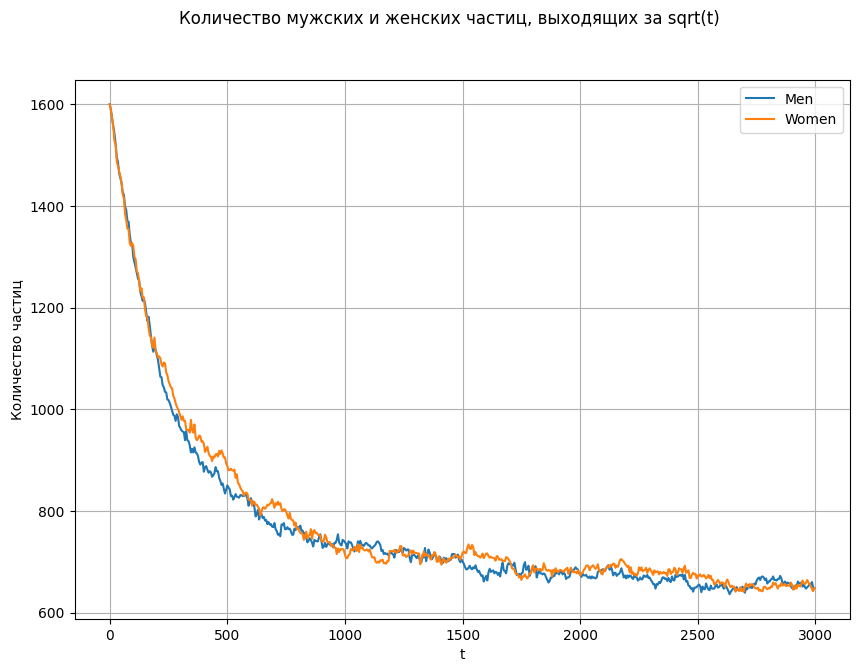

In [161]:
interval_tree = get_points_share_sqrt(all_points, 3000, shares=False)


100%|█████████████████████████████████████████| 600/600 [00:11<00:00, 52.49it/s]


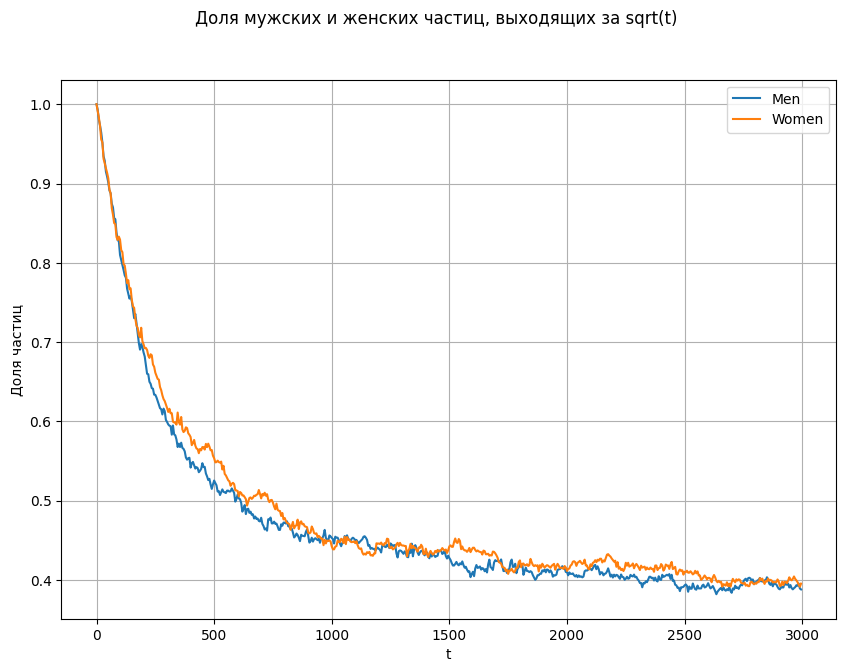

In [162]:
_ = get_points_share_sqrt(all_points, 3000, interval_tree=interval_tree, shares=True)

## Большие уклонения с размножением и гибелью в 0, d = 3

In [28]:
allowed_jumps = get_unit_vectors(3)

In [29]:
def beta(p, k, l):
    if p.point_type == 1:
        return 0
    
    dim = p.x.shape[0]
    
    at_zero = np.sum(np.array(list(map(lambda x: round(x, 0), p.x))) == 0) == dim
    
    if p.point_type == 2 and at_zero:
        if k == 1:
            if l == 1:
                return 0.4
        if k == 0:
            if l == 2:
                return 0.4
    else:
        return 0

In [30]:
%%time

all_points = run_simulation(
    mu = mu,
    max_steps=200000000,
    init_points=init_points,
    T=3000,
    beta=beta,
    plot=False,
    allowed_jumps=allowed_jumps,
    dim=3
)

  2%|▌                         | 3948631/200000000 [03:12<2:39:35, 20474.15it/s]


CPU times: user 3min 14s, sys: 11.5 s, total: 3min 25s
Wall time: 3min 17s


100%|█████████████████████████████| 3948631/3948631 [00:36<00:00, 109007.56it/s]

100%|█████████████████████████████████████████| 300/300 [00:06<00:00, 43.27it/s]


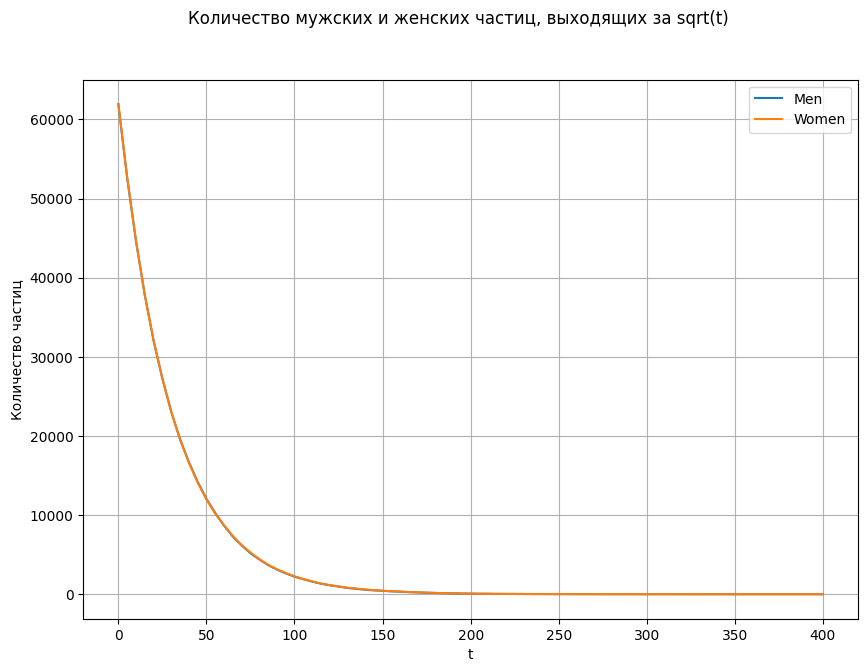

In [31]:
interval_tree = get_points_share_sqrt(all_points, 1500, shares=False)


100%|█████████████████████████████████████████| 300/300 [00:06<00:00, 43.38it/s]


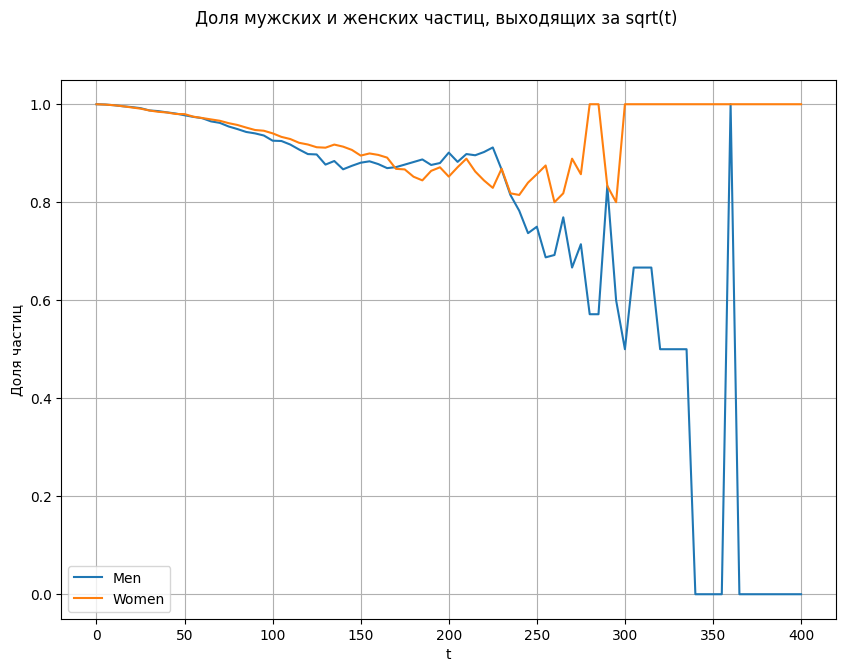

In [32]:
_ = get_points_share_sqrt(all_points, 1500, interval_tree=interval_tree, shares=True)

In [20]:
allowed_jumps = [
    (-1),
    (1)
]

In [21]:
def beta(p, k, l):
    if p.point_type == 1:
        return 0
    
    if p.point_type == 2:
        if k == 1:
            if l == 1:
                return 0.209
        if k == 0:
            if l == 2:
                return 0.209
    else:
        return 0

In [25]:
%%time

all_points = run_simulation(
    mu = mu,
    max_steps=50000000,
    init_points=init_points,
    T=3000,
    beta=beta,
    plot=False,
    allowed_jumps=allowed_jumps,
    dim=1
)

100%|███████████████████████████| 50000000/50000000 [2:55:19<00:00, 4752.97it/s]


CPU times: user 2h 49min 50s, sys: 9min 6s, total: 2h 58min 56s
Wall time: 2h 56min 52s


In [26]:
save_simulation(all_points, 'simulations/big_evsasions_dim1_209', dim=1)

In [21]:
all_points = load_simulation('simulations/big_evsasions_dim1_209', dim=1)

  1%|▎                            | 102635/10000000 [16:24<26:22:06, 104.26it/s]


KeyboardInterrupt: 

100%|███████████████████████████████████████| 600/600 [3:32:54<00:00, 21.29s/it]


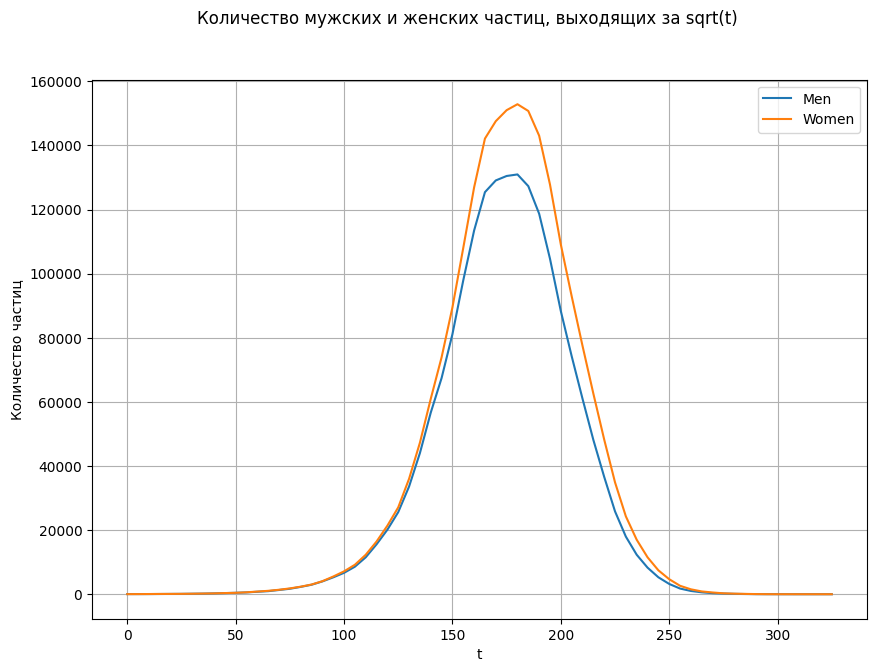

In [27]:
interval_tree = get_points_share_sqrt(all_points, 3000, shares=False)

 10%|████▏                                   | 62/600 [28:42<2:53:21, 19.33s/it]/var/folders/5l/czs0hh2d2_v2h0x66nnd_hrmpdlz42/T/ipykernel_77901/446783186.py:36: RuntimeWarning:

invalid value encountered in scalar divide

100%|███████████████████████████████████████| 600/600 [3:25:06<00:00, 20.51s/it]


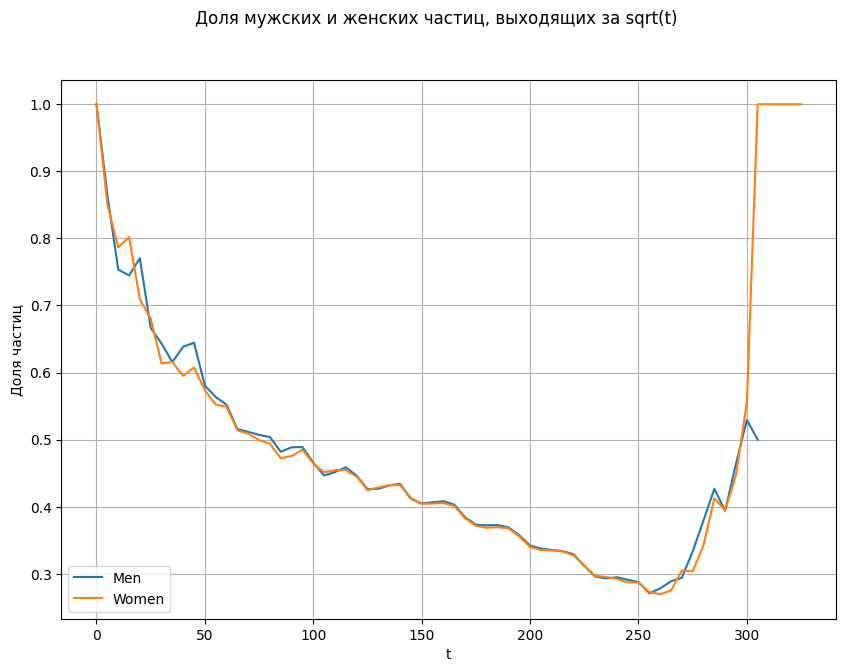

In [28]:
_ = get_points_share_sqrt(all_points, 3000, interval_tree=interval_tree, shares=True)

In [ ]:
plot_points_interactive_plotly(all_points, 2000, 1, width=1000, height=1000)

## Большие уклонения мужских или женских частиц, выходящих за sqrt(t) при симметричном блуждании, d = 2

In [27]:
allowed_jumps = [
    (0, 1),
    (1, 0),
    (0, -1),
    (-1, 0)
]

In [28]:
def beta(p, k, l):
    if p.point_type == 1:
        return 0
    
    if p.point_type == 2:
        if k == 1:
            if l == 1:
                return 0.109
        if k == 0:
            if l == 2:
                return 0.109
    else:
        return 0

In [29]:
%%time

all_points = run_simulation(
    mu = mu,
    max_steps=100000000,
    init_points=init_points,
    T=3000,
    beta=beta,
    plot=False,
    allowed_jumps=allowed_jumps,
    dim=2
)

100%|████████████████████████| 100000000/100000000 [2:27:46<00:00, 11278.46it/s]


CPU times: user 1h 25min 9s, sys: 44min 4s, total: 2h 9min 14s
Wall time: 2h 33min 20s


In [30]:
save_simulation(all_points, 'simulations/big_evsasions_dim2', dim=2)

100%|█████████████████████████████████████████| 400/400 [48:45<00:00,  7.31s/it]


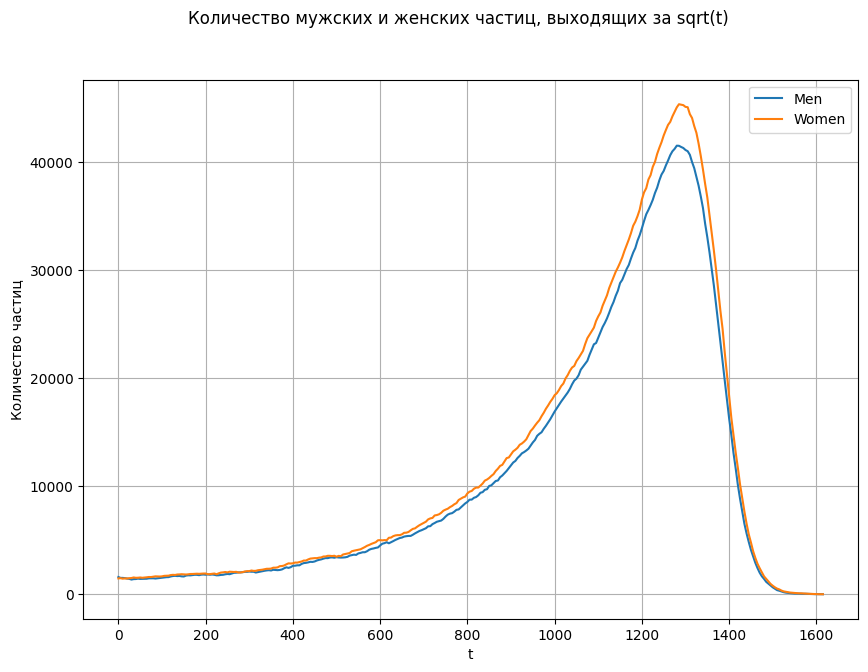

In [31]:
interval_tree = get_points_share_sqrt(all_points, 2000, shares=False)

 80%|█████████████████████████████████        | 322/400 [38:35<09:04,  6.99s/it]/var/folders/5l/czs0hh2d2_v2h0x66nnd_hrmpdlz42/T/ipykernel_73892/446783186.py:36: RuntimeWarning:

invalid value encountered in scalar divide

 81%|█████████████████████████████████        | 323/400 [38:42<09:03,  7.06s/it]/var/folders/5l/czs0hh2d2_v2h0x66nnd_hrmpdlz42/T/ipykernel_73892/446783186.py:37: RuntimeWarning:

invalid value encountered in scalar divide

100%|█████████████████████████████████████████| 400/400 [48:26<00:00,  7.27s/it]


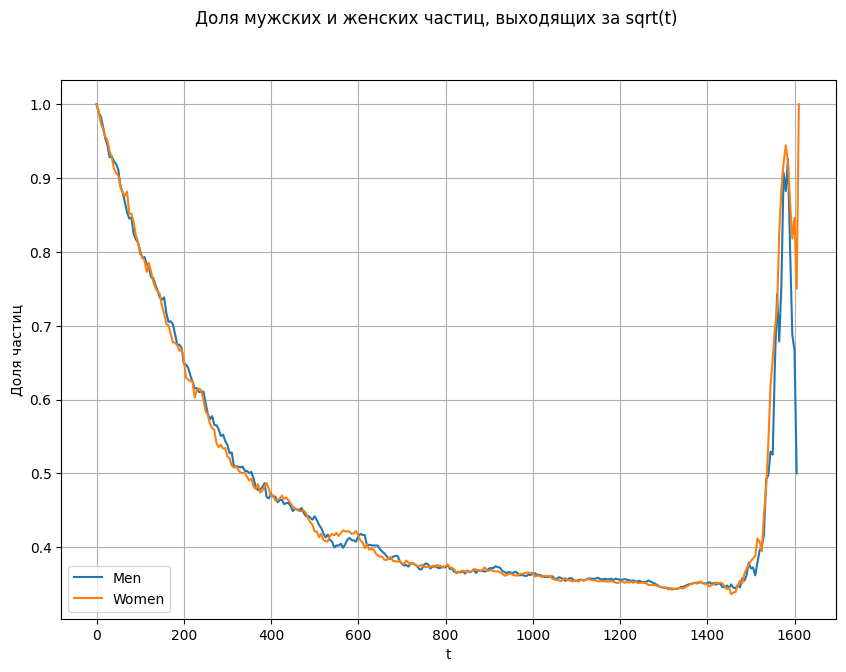

In [32]:
_ = get_points_share_sqrt(all_points, 2000, interval_tree = interval_tree, shares=True)

In [ ]:
plot_points_interactive_plotly(all_points, 2000, 2, width=1000, height=1000)

## Большие уклонения мужских или женских частиц, выходящих за sqrt(t) при симметричном блуждании, d = 3

In [21]:
allowed_jumps = [
    (0, 0, 1),
    (0, 1, 0),
    (1, 0, 0),
    (0, 0, -1),
    (0, -1, 0),
    (-1, 0, 0)
]

In [22]:
def beta(p, k, l):
    if p.point_type == 1:
        return 0
    
    if p.point_type == 2:
        if k == 1:
            if l == 1:
                return 0.109
        if k == 0:
            if l == 2:
                return 0.109
    else:
        return 0

In [2]:
%%time

all_points = run_simulation(
    mu = mu,
    max_steps=200000000,
    init_points=init_points,
    T=3000,
    beta=beta,
    plot=False,
    allowed_jumps=allowed_jumps,
    dim=3
)

NameError: name 'run_simulation' is not defined

In [ ]:
save_simulation(all_points, 'simulations/big_evsasions_dim3', dim=3)

In [ ]:
interval_tree = get_points_share_sqrt(all_points, 2000, shares=False)

In [ ]:
_ = get_points_share_sqrt(all_points, 2000, interval_tree=interval_tree, shares=True)

In [ ]:
plot_points_interactive_plotly(all_points, 2000, 3, width=1000, height=1000)

In [ ]:
from numba import jit, prange

def get_points_cnts(points, T):
    ts = []
    
    interval_tree = build_interval_tree(points)
    
    counts_mens = []
    counts_womens = []
    
    
    for t in np.arange(0.01, T, 1):
        idx = list(map(lambda i: i.data, interval_tree.at(t)))
        if len(idx) == 0:
            continue
        
        ts.append(t)
        
        points_t = points[idx]
        
        color_dict = {1: 'blue', 2: 'red'}
        
        labels = np.array(list(map(lambda p: p.point_type, points_t)))
        coords = np.array(list(map(lambda p: p.x, points_t)))
        
        dists = np.apply_along_axis(func1d=np.sum, arr=coords * coords, axis=1)
        
        count_mens = np.sum(labels == 1)
        count_womens = np.sum(labels == 2)
        
        counts_mens.append(count_mens)
        counts_womens.append(count_womens)
        
        
    plt.plot(ts, counts_mens, label='Men')
    plt.plot(ts, counts_womens, label='Women')
    plt.xlabel('t')
    plt.ylabel('Количество частиц')
    plt.suptitle('Количество частиц в зависимости от t')
        
    plt.legend()
    plt.show()

# Центры размножения ($b_0 = b_2$) в 0 (умирает только в 0), dim=1

In [ ]:
def beta(p, k, l):
    if p.point_type == 1:
        return 0
    
    if p.point_type == 2:
        if k == 1:
            if l == 1:
                return 0.109
        if k == 0:
            if l == 2:
                return 0.109
    else:
        return 0

In [ ]:
def mu(p):
    if int(p.x[0]) == 0:
        return 0.5
    return 0

In [ ]:
allowed_jumps = [
    (-1),
    (1)
]

In [ ]:
all_points = run_simulation(
    mu = mu,
    max_steps=5000000,
    init_points=init_points,
    T=2000,
    beta=beta,
    plot=False,
    allowed_jumps=allowed_jumps,
    dim=1
)

In [ ]:
save_simulation(all_points, 'simulations/die_and_birth_only_at_zero_dim1', dim=1)

In [ ]:
plot_points_interactive_plotly(all_points, 2000, 1, width=1000, height=1000)

In [ ]:
get_points_cnts(all_points, 2000)

# Центры размножения ($b_0 = b_2$) в любой точке (умирает в любой точке), dim=1

In [ ]:
def beta(p, k, l, point_tree_dict):
    if p.point_type == 1:
        return 0
    
    if p.point_type == 2:
        if k == 1:
            if l == 1:
                return 0.5
        if k == 0:
            if l == 2:
                return 0.5      
    else:
        return 0

In [ ]:
def mu(p):
    return 0.5

In [ ]:
allowed_jumps = [
    (-1),
    (1)
]

In [ ]:
all_points = run_simulation(
    mu = mu,
    max_steps=5000000,
    init_points=init_points,
    T=2000,
    beta=beta,
    plot=False,
    allowed_jumps=allowed_jumps,
    dim=1
)

In [ ]:
save_simulation(all_points, 'simulations/die_and_birth_everywhere_dim1', dim=1)

In [ ]:
plot_points_interactive_plotly(all_points, 2000, 1, width=1000, height=1000)

In [ ]:
get_points_cnts(all_points, 2000)

# Центры размножения ($b_0 = b_2$) в 0 (умирает только в 0), dim=2

In [ ]:
def beta(p, k, l, point_tree_dict):
    if p.point_type == 1:
        return 0
    
    if p.point_type == 2 and int(p.x[0]) == 0 and int(p.x[1]) == 0:
        if k == 1:
            if l == 1:
                return 0.5
        if k == 0:
            if l == 2:
                return 0.5      
    else:
        return 0

In [ ]:
def mu(p):
    if int(p.x[0]) == 0 and int(p.x[1]) == 0:
        return 0.5
    return 0

In [ ]:
allowed_jumps = [
    (0, 1),
    (1, 0),
    (0, -1),
    (-1, 0)
]

In [ ]:
all_points = run_simulation(
    mu = mu,
    max_steps=5000000,
    init_points=init_points,
    T=2000,
    beta=beta,
    plot=False,
    allowed_jumps=allowed_jumps,
    dim=2
)

In [ ]:
save_simulation(all_points, 'simulations/die_and_birth_only_at_zero_dim2', dim=2)

In [ ]:
get_points_cnts(all_points, 1250)

# Центры размножения ($b_0 = b_2$) в любой точке (умирает в любой точке), dim=2

In [ ]:
def beta(p, k, l, point_tree_dict):
    if p.point_type == 1:
        return 0
    
    if p.point_type == 2:
        if k == 1:
            if l == 1:
                return 0.5
        if k == 0:
            if l == 2:
                return 0.5      
    else:
        return 0

In [ ]:
def mu(p):
    return 0.5

In [ ]:
allowed_jumps = [
    (0, 1),
    (1, 0),
    (0, -1),
    (-1, 0)
]

In [ ]:
all_points = run_simulation(
    mu = mu,
    max_steps=5000000,
    init_points=init_points,
    T=2000,
    beta=beta,
    plot=False,
    allowed_jumps=allowed_jumps,
    dim=2
)

In [ ]:
save_simulation(all_points, 'simulations/die_and_birth_everywhere_dim2', dim=2)

In [ ]:
get_points_cnts(all_points, 1250)

# Центры размножения ($b_0 = b_2$) в 0 (умирает только в 0), dim=3

In [ ]:
def beta(p, k, l, point_tree_dict):
    if p.point_type == 1:
        return 0
    
    if p.point_type == 2 and int(p.x[0]) == 0 and int(p.x[1]) == 0 and int(p.x[2]) == 0:
        if k == 1:
            if l == 1:
                return 0.5
        if k == 0:
            if l == 2:
                return 0.5      
    else:
        return 0

In [ ]:
def mu(p):
    if int(p.x[0]) == 0 and int(p.x[1]) == 0 and int(p.x[2]) == 0:
        return 0.5
    return 0

In [ ]:
allowed_jumps = [
    (0, 0, 1),
    (0, 1, 0),
    (1, 0, 0),
    (0, 0, -1),
    (0, -1, 0),
    (-1, 0, 0)
]

In [ ]:
all_points = run_simulation(
    mu = mu,
    max_steps=5000000,
    init_points=init_points,
    T=2000,
    beta=beta,
    plot=False,
    allowed_jumps=allowed_jumps,
    dim=3
)

In [ ]:
save_simulation(all_points, 'simulations/die_and_birth_only_at_zero_dim3', dim=3)

In [ ]:
get_points_cnts(all_points, 2000)

In [ ]:
def beta(p, k, l, point_tree_dict):
    if p.point_type == 1:
        return 0
    
    if p.point_type == 2:
        if k == 1:
            if l == 1:
                return 0.5
        if k == 0:
            if l == 2:
                return 0.5      
    else:
        return 0

In [ ]:
def mu(p):
    return 0.5

In [ ]:
allowed_jumps = [
    (0, 0, 1),
    (0, 1, 0),
    (1, 0, 0),
    (0, 0, -1),
    (0, -1, 0),
    (-1, 0, 0)
]

In [ ]:
all_points = run_simulation(
    mu = mu,
    max_steps=5000000,
    init_points=init_points,
    T=2000,
    beta=beta,
    plot=False,
    allowed_jumps=allowed_jumps,
    dim=3
)

In [ ]:
save_simulation(all_points, 'simulations/die_and_birth_everywhere_dim3', dim=3)

In [ ]:
get_points_cnts(all_points, 2000)